## Dogs vs Cats - with augmentation

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import random
from shutil import copyfile

In [ ]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /content/cats_and_dogs_filtered.zip

--2021-08-01 18:29:02--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 142.250.101.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M   260MB/s    in 0.3s    

2021-08-01 18:29:03 (260 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
# content -> cats_and_dogs_filtered -> train -> cats, dogs
# content -> cats_and_dogs_filtered -> validation -> cats, dogs

import os
import zipfile

local_zip = '/content/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
base_dir = '/content/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.289.jpg', 'cat.275.jpg', 'cat.168.jpg', 'cat.902.jpg', 'cat.660.jpg', 'cat.339.jpg', 'cat.628.jpg', 'cat.595.jpg', 'cat.140.jpg', 'cat.990.jpg']
['dog.12.jpg', 'dog.39.jpg', 'dog.42.jpg', 'dog.210.jpg', 'dog.228.jpg', 'dog.839.jpg', 'dog.369.jpg', 'dog.723.jpg', 'dog.305.jpg', 'dog.646.jpg']


In [ ]:
print('total training cat images :', len(os.listdir(train_cats_dir)))
print('total training dog images :', len(os.listdir(train_dogs_dir)))

print('total validation cat images :', len(os.listdir(validation_cats_dir)))
print('total validation dog images :', len(os.listdir(validation_dogs_dir)))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


In [ ]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color

    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [ ]:
# RMS is preferrable to SGD because RMSprop automates learning-rate tuning for us
# Adam, AdaGrad will also do good

from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

# rescale all images by 1./255.
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )


# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=100,                    # steps_per_epoch = total training records / batch size = 2000/20
                    epochs=50,
                    validation_steps=50,                    # validation_steps = total validation records / batch size = 1000/20
                    verbose=2)

Epoch 1/50
100/100 - 48s - loss: 0.7632 - accuracy: 0.5435 - val_loss: 0.6404 - val_accuracy: 0.6350
Epoch 2/50
100/100 - 17s - loss: 0.6586 - accuracy: 0.5990 - val_loss: 0.6129 - val_accuracy: 0.6500
Epoch 3/50
100/100 - 17s - loss: 0.6363 - accuracy: 0.6420 - val_loss: 0.6212 - val_accuracy: 0.6180
Epoch 4/50
100/100 - 16s - loss: 0.6196 - accuracy: 0.6490 - val_loss: 0.5796 - val_accuracy: 0.6840
Epoch 5/50
100/100 - 16s - loss: 0.6105 - accuracy: 0.6800 - val_loss: 0.5587 - val_accuracy: 0.7070
Epoch 6/50
100/100 - 17s - loss: 0.6085 - accuracy: 0.6695 - val_loss: 0.9436 - val_accuracy: 0.6070
Epoch 7/50
100/100 - 17s - loss: 0.6168 - accuracy: 0.6670 - val_loss: 0.6754 - val_accuracy: 0.6530
Epoch 8/50
100/100 - 17s - loss: 0.5951 - accuracy: 0.6795 - val_loss: 0.5625 - val_accuracy: 0.6970
Epoch 9/50
100/100 - 17s - loss: 0.5924 - accuracy: 0.6830 - val_loss: 0.5317 - val_accuracy: 0.7170
Epoch 10/50
100/100 - 16s - loss: 0.5681 - accuracy: 0.7060 - val_loss: 0.5330 - val_accura

Text(0.5, 1.0, 'Training and validation loss')

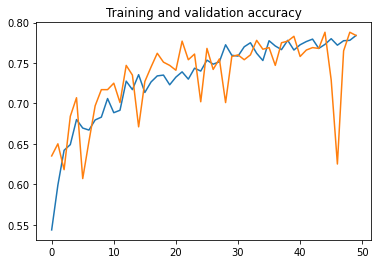

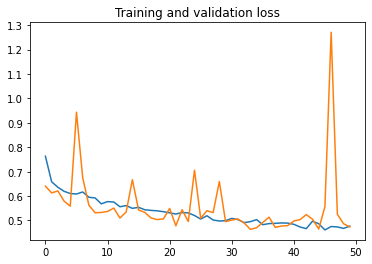

In [ ]:
# Retrieve a list of list results on training and test data
# sets for each training epoch
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

# Plot training and validation loss per epoch
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss')

# blue - training, orange - validation

## Horse vs Human - with augmentation

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /content/horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /content/validation-horse-or-human.zip

--2021-08-01 18:55:09--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 2607:f8b0:4023:c0d::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/content/horse-or-human.zip’

/content/horse-or-h 100%[===================>] 142.65M   139MB/s    in 1.0s    

2021-08-01 18:55:10 (139 MB/s) - ‘/content/horse-or-human.zip’ saved [149574867/149574867]

--2021-08-01 18:55:11--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 2607:f8b0:4023:c0b::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting resp

In [ ]:
import os
import zipfile

local_zip = '/content/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/horse-or-human')
local_zip = '/content/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/validation-horse-or-human')
zip_ref.close()
# Directory with our training horse pictures
train_horse_dir = os.path.join('/content/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/content/horse-or-human/humans')

# Directory with our training horse pictures
validation_horse_dir = os.path.join('/content/validation-horse-or-human/horses')

# Directory with our training human pictures
validation_human_dir = os.path.join('/content/validation-horse-or-human/humans')

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/content/horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/content/validation-horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=40,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/40
8/8 [==============================] - 25s 3s/step - loss: 0.6936 - accuracy: 0.5039 - val_loss: 0.6396 - val_accuracy: 0.8789
Epoch 2/40
8/8 [==============================] - 22s 3s/step - loss: 0.6767 - accuracy: 0.6507 - val_loss: 0.6108 - val_accuracy: 0.7734
Epoch 3/40
8/8 [==============================] - 25s 3s/step - loss: 0.6354 - accuracy: 0.7061 - val_loss: 0.6389 - val_accuracy: 0.5703
Epoch 4/40
8/8 [==============================] - 22s 3s/step - loss: 0.5905 - accuracy: 0.6741 - val_loss: 0.7079 - val_accuracy: 0.5508
Epoch 5/40
8/8 [==============================] - 21s 3s/step - loss: 0.5471 - accuracy: 0.7330 - val_loss: 1.6582 - val_accuracy: 0.5000
Epoch 6/40
8/8 [==============================] - 23s 3s/step - loss: 0.6049 - accuracy: 0.6852 - val_loss: 0.7132 - val_accuracy: 0.6250
Epoch 7/40
8/8 [==============================] - 22s 3s/step - loss: 0.5290 - accuracy: 0.7297 - val_loss: 0.6550 - val_accuracy: 0.6992
Epoch 8/40
8/8 [==================

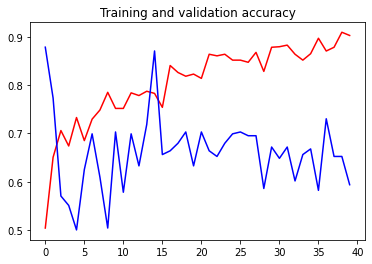

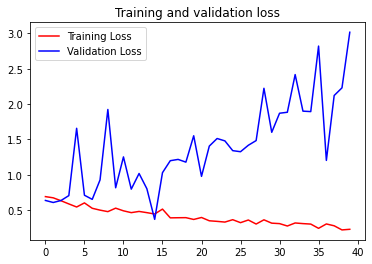

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Dogs vs Cats Full Dataset - with augmentation

**Exercise 6**

In this exercise you will train a CNN on the FULL Cats-v-dogs dataset. This will require you doing a lot of data preprocessing because the dataset isn't split into training and validation for you.

In [1]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/content/cats-and-dogs.zip"

--2021-08-02 06:13:28--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.73.0.105, 2600:1409:3800:18d::e59, 2600:1409:3800:1ab::e59
Connecting to download.microsoft.com (download.microsoft.com)|104.73.0.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/content/cats-and-dogs.zip’

/content/cats-and-d 100%[===================>] 786.68M   211MB/s    in 3.8s    

2021-08-02 06:13:32 (206 MB/s) - ‘/content/cats-and-dogs.zip’ saved [824894548/824894548]



In [3]:
import os
import zipfile

local_zip = '/content/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
# content -> PetImages -> cats, dogs
# training and validation directory not given separately

print(len(os.listdir('/content/PetImages/Cat/')))
print(len(os.listdir('/content/PetImages/Dog/')))

12501
12501


In [5]:
try:
    os.mkdir('/content/cats-v-dogs')
    os.mkdir('/content/cats-v-dogs/training')
    os.mkdir('/content/cats-v-dogs/testing')
    os.mkdir('/content/cats-v-dogs/training/cats')
    os.mkdir('/content/cats-v-dogs/training/dogs')
    os.mkdir('/content/cats-v-dogs/testing/cats')
    os.mkdir('/content/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [6]:
# it will split the directory and separate train and validation images
# 90% images will be copied to training folder
# 10% to validation

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

In [7]:
CAT_SOURCE_DIR = "/content/PetImages/Cat/"
TRAINING_CATS_DIR = "/content/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/content/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/content/PetImages/Dog/"
TRAINING_DOGS_DIR = "/content/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/content/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [8]:
print(len(os.listdir('/content/cats-v-dogs/training/cats/')))
print(len(os.listdir('/content/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/content/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/content/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [10]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/content/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/content/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

Found 22499 images belonging to 2 classes.
Found 2499 images belonging to 2 classes.


In [12]:
history = model.fit(train_generator,
                    epochs=5,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/5
174/225 [======================>.......] - ETA: 36s - loss: 0.7060 - accuracy: 0.5735

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

225/225 [==============================] - 214s 808ms/step - loss: 0.6922 - accuracy: 0.5874 - val_loss: 0.6416 - val_accuracy: 0.6383
Epoch 2/5
225/225 [==============================] - 179s 797ms/step - loss: 0.6078 - accuracy: 0.6716 - val_loss: 0.5801 - val_accuracy: 0.6987
Epoch 3/5
225/225 [==============================] - 179s 796ms/step - loss: 0.5713 - accuracy: 0.6980 - val_loss: 0.5731 - val_accuracy: 0.7019
Epoch 4/5
225/225 [==============================] - 180s 800ms/step - loss: 0.5516 - accuracy: 0.7173 - val_loss: 0.5561 - val_accuracy: 0.7071
Epoch 5/5
225/225 [==============================] - 180s 799ms/step - loss: 0.5282 - accuracy: 0.7346 - val_loss: 0.5299 - val_accuracy: 0.7319


<Figure size 432x288 with 0 Axes>

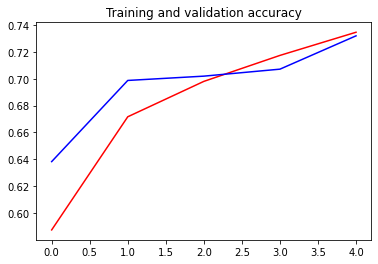

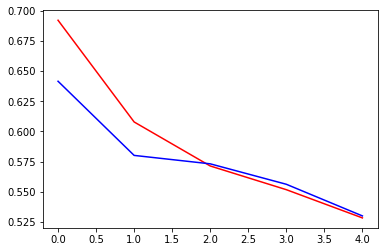

<Figure size 432x288 with 0 Axes>

In [13]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.figure()

In [16]:
from google.colab import files
from keras.preprocessing import image
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving best-girl-cat-names-1606245046.jpg to best-girl-cat-names-1606245046.jpg
[1.0741011e-29]
best-girl-cat-names-1606245046.jpg is a cat
